In [314]:
import numpy as np, matplotlib.pyplot as plt, networkx as nx, pickle, json, gzip
import pandas as pd
%matplotlib inline

## Set parameters

N_READS: Cutoff for the min number of reads supporting a given UMI/GFP-BC pair in a particular cell

N_UMIS: Cutoff for the min number of UMIs supporting a given cell/GFP-BC pair

N_HAMMING: Cutoff for the max hamming distance to collapse two GFP-BCs

CELL_BCS_PATH: Path to a .txt file with one cell-BC per line, corresponding to rows of the gene expression counts matrix

LIB_NAMES_PATH: Path to a .txt file with one library name per line, corresponding to rows of the gene expression counts matrix



In [315]:
N_READS = 10
N_UMIS = 3
N_HAMMING = 3

# CELL_BCS_PATH = 'cell_bcs_flat.txt'
# LIB_NAMES_PATH = 'samp_id_flat.txt'

In [316]:
cell_barcodes1 = pd.read_table('Differentiated/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)
cell_barcodes2 = pd.read_table('Regular/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)

cell_barcodes1.loc[:, 'library'] = 'Differentiated'
cell_barcodes2.loc[:, 'library'] = 'Regular'
cell_barcodes = pd.concat([cell_barcodes1, cell_barcodes2])
cell_barcodes.iloc[:, 0] = list(map(lambda x:x.split('-')[0], list(cell_barcodes.iloc[:, 0].values)))

In [317]:
cell_barcodes1.shape, cell_barcodes1.iloc[:, 0].unique().shape

((4070, 2), (4070,))

In [318]:
cell_bcs = cell_barcodes.iloc[:, 0].values
lib_names = cell_barcodes.iloc[:, 1].values
cell_barcodes.head()

,0,library
0,AAACCCACAAACGTGG,Differentiated
1,AAACCCACACAGCGCT,Differentiated
2,AAACGAAAGCAGCGAT,Differentiated
3,AAACGAACAATCGCCG,Differentiated
4,AAACGAACAGCACGAA,Differentiated


In [319]:
cell_barcodes1.head()

,0,library
0,AAACCCACAAACGTGG-1,Differentiated
1,AAACCCACACAGCGCT-1,Differentiated
2,AAACGAAAGCAGCGAT-1,Differentiated
3,AAACGAACAATCGCCG-1,Differentiated
4,AAACGAACAGCACGAA-1,Differentiated


In [320]:
cell_barcodes1 = list(map(lambda x:x.split('-')[0], cell_barcodes1.iloc[:, 0].values))
cell_barcodes2 = list(map(lambda x:x.split('-')[0], cell_barcodes2.iloc[:, 0].values))

cell_barcodes = {'Differentiated': cell_barcodes1, 'Regular': cell_barcodes2}

In [321]:
cell_barcodes1[:10]

['AAACCCACAAACGTGG',
 'AAACCCACACAGCGCT',
 'AAACGAAAGCAGCGAT',
 'AAACGAACAATCGCCG',
 'AAACGAACAGCACGAA',
 'AAACGAATCCCATTCG',
 'AAACGCTCAGAGGAAA',
 'AAACGCTCAGGAGGTT',
 'AAACGCTCATACTGTG',
 'AAACGCTGTGAGACGT']

In [323]:
# cell_barcodes.shape, cell_bcs.shape, lib_names.shape

## Read input files

In [6]:
# cell_bcs = open(CELL_BCS_PATH).read().strip('\n').split('\n')
# lib_names = open(LIB_NAMES_PATH).read().strip('\n').split('\n')

In [178]:
cell_bcs[:5], lib_names[:5]

(array(['AAACCCACAAACGTGG', 'AAACCCACACAGCGCT', 'AAACGAAAGCAGCGAT',
        'AAACGAACAATCGCCG', 'AAACGAACAGCACGAA'], dtype=object),
 array(['Differentiated', 'Differentiated', 'Differentiated',
        'Differentiated', 'Differentiated'], dtype=object))

## Load data and count reads

Read in the output of step 1 (LARRY_sorting_and_filtering.py) and count the number of reads supporting each (Sample, Cell-BC, UMI, GFP-BC) combination

In [324]:
# counts = {}
# # f = gzip.open('LARRY_sorted_and_filtered_barcodes.fastq.gz')
# import glob
# for inf in glob.glob('*/*BC.txt.gz'):
#     sample = os.path.basename(inf).split('_')[0]  
#     print(sample)
#     f = open(inf)
#     l = f.readline().strip('\n')
#     current_tag = []
#     i = 0
#     print('Reading in all barcodes')
#     while not (l == '' and len(current_tag)==0):
#         i += 1
#         if i % (1000000)==0: print('Processed '+repr(int(i/3))+' reads')
#         if l == '':
#             current_tag = []
#         elif l[0] == '>':
#             current_tag = l[1:].split(',')
#         elif l != '' and len(current_tag)==3:
#             current_tag.append(l)
#             current_tag = tuple(current_tag)
#             #print(current_tag[1])
#             if current_tag[1] in cell_barcodes[current_tag[0]]:
#                 if not current_tag in counts: counts[current_tag] = 0
#                 counts[current_tag] += 1                 
#         l = f.readline().strip('\n')
#     f.close()
#     #break

In [330]:
import gzip
counts = {}
# f = gzip.open('LARRY_sorted_and_filtered_barcodes.fastq.gz')
import glob
for inf in glob.glob('*2/*BC.txt.gz'):
    sample = os.path.basename(inf).split('_')[0]  
    print(sample)
    f = gzip.open(inf)
    l = f.readline().decode("utf-8").strip('\n')
    current_tag = []
    i = 0
    print('Reading in all barcodes')
    while not (l == '' and len(current_tag)==0):
        i += 1
        if i % (3*10**6)==0: print('Processed '+repr(int(i/3))+' reads')
        if l == '':
            current_tag = []
        elif l[0] == '>':
            current_tag = l[1:].split(',')
        elif l != '' and len(current_tag)==3:
            current_tag.append(l)
            current_tag = tuple(current_tag)
            if not current_tag in counts: counts[current_tag] = 0
            counts[current_tag] += 1

        l = f.readline().decode("utf-8").strip('\n')
    f.close()

Differentiated
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Processed 6000000 reads
Processed 7000000 reads
Processed 8000000 reads
Processed 9000000 reads
Differentiated
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Processed 6000000 reads
Processed 7000000 reads
Processed 8000000 reads
Processed 9000000 reads
Differentiated
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Processed 6000000 reads
Processed 7000000 reads
Processed 8000000 reads
Processed 9000000 reads
Differentiated
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Processed 6000000 reads
Processed 7000000 reads
Processed 8000000 reads
Proc

In [331]:
len(counts.keys())

10452547

In [332]:
import pickle

In [312]:
# with open('larry_barcodes.pkl', 'wb') as pkl:
#     pickle.dump(counts, pkl)

In [313]:
# !du -sh larry_barcodes.pkl

1.1G	larry_barcodes.pkl


## Filter by number of reads
Continue with analysis with (Sample, Cell-BC, UMI, GFP-BC) combinations supported by at least N_READS reads

In [333]:
num_reads = [v for k,v in counts.items()]

In [91]:
# sum(num_reads) # all cell barcode

138024033

In [334]:
sum(num_reads) # condition specific barcode

138014962

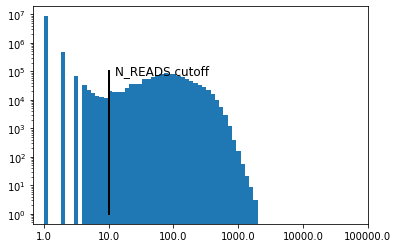

In [87]:
# # To specify the number of ticks on both or any single axes
# plt.hist(np.log(num_reads)/np.log(10), bins=50)
# plt.locator_params(axis='x', nbins=5)
# #pyplot.locator_params(axis='x', nbins=10)
# plt.plot([np.log(N_READS)/np.log(10),
#           np.log(N_READS)/np.log(N_READS)],[1,10**5],'-k',linewidth=2)
# plt.xticks(range(6),np.logspace(0,5,6))
# plt.text(np.log(N_READS)/np.log(10)*1.1,10**5*.8,'N_READS cutoff', fontsize=12)
# plt.yscale('log')

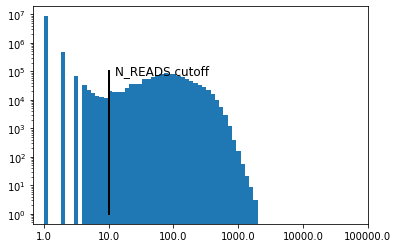

In [335]:
# To specify the number of ticks on both or any single axes
plt.hist(np.log(num_reads)/np.log(10), bins=50)
plt.locator_params(axis='x', nbins=5)
#pyplot.locator_params(axis='x', nbins=10)
plt.plot([np.log(N_READS)/np.log(10),
          np.log(N_READS)/np.log(N_READS)],[1,10**5],'-k',linewidth=2)
plt.xticks(range(6),np.logspace(0,5,6))
plt.text(np.log(N_READS)/np.log(10)*1.1,10**5*.8,'N_READS cutoff', fontsize=12)
plt.yscale('log')

In [88]:
# counts_filtered = {k:v for k,v in counts.items() if v >= N_READS}
# print('Retaining '+repr(len(counts_filtered))+ ' out of '+repr(len(counts))+' (Sample,Cell-BC,UMI,GFP-BC) combinations')

Retaining 1177481 out of 10455433 (Sample,Cell-BC,UMI,GFP-BC) combinations


In [336]:
counts_filtered = {k:v for k,v in counts.items() if v >= N_READS}
print('Retaining '+repr(len(counts_filtered))+ ' out of '+repr(len(counts))+' (Sample,Cell-BC,UMI,GFP-BC) combinations')

Retaining 1177403 out of 10452547 (Sample,Cell-BC,UMI,GFP-BC) combinations


## Collapse GFP-BCs by hamming distance

In [337]:
def hamming(bc1,bc2): return np.sum([x1 != x2 for x1,x2 in zip(bc1,bc2)])

all_gfp_bcs = sorted(set([k[3] for k in counts_filtered]))
good_gfp_bcs = []
bc_map = {}
for i,bc1 in enumerate(all_gfp_bcs):
    if i > 0 and i % 500 == 0: print('Mapped '+repr(i)+' out of '+repr(len(all_gfp_bcs))+' barcodes')
    mapped = False
    for bc2 in good_gfp_bcs:
        if hamming(bc1,bc2) <= N_HAMMING:
            mapped = True
            bc_map[bc1] = bc2
            break
    if not mapped:
        good_gfp_bcs.append(bc1)

print('\nCollapsed '+repr(len(bc_map))+' barcodes')
for bc in good_gfp_bcs: bc_map[bc] = bc

Mapped 500 out of 9938 barcodes
Mapped 1000 out of 9938 barcodes
Mapped 1500 out of 9938 barcodes
Mapped 2000 out of 9938 barcodes
Mapped 2500 out of 9938 barcodes
Mapped 3000 out of 9938 barcodes
Mapped 3500 out of 9938 barcodes
Mapped 4000 out of 9938 barcodes
Mapped 4500 out of 9938 barcodes
Mapped 5000 out of 9938 barcodes
Mapped 5500 out of 9938 barcodes
Mapped 6000 out of 9938 barcodes
Mapped 6500 out of 9938 barcodes
Mapped 7000 out of 9938 barcodes
Mapped 7500 out of 9938 barcodes
Mapped 8000 out of 9938 barcodes
Mapped 8500 out of 9938 barcodes
Mapped 9000 out of 9938 barcodes
Mapped 9500 out of 9938 barcodes

Collapsed 3159 barcodes


In [338]:
len(bc_map)

9938

## Filter GFP-barcodes by UMI
Index (UMI, GFP-BC) combinations to cells, then filter out BCs supported by fewer than N_UMIS UMIs

In [339]:
list(counts_filtered.keys())[:3]

[('Differentiated',
  'TATTTCGGTACTGGGA',
  'TTCCCGATCAAA',
  'CCAATGGCGCCATGCAACCTCCGAAAACG'),
 ('Differentiated',
  'CATCCCATCTCAACCC',
  'GATCGAATGGTA',
  'CAAGTGACAGCATGTGACGCTTGACGACG'),
 ('Differentiated',
  'TTCCAATCAGACCCGT',
  'CCTACTACAGTA',
  'GGCGTGAACCCAGGCCACTCCTGAGCCTG')]

In [340]:
len(cell_bcs), len(cell_data)

(7897, 7897)

Regular TTTGTTGTCTACCCAC

Final annotation has 4918 clones in 5320 cells


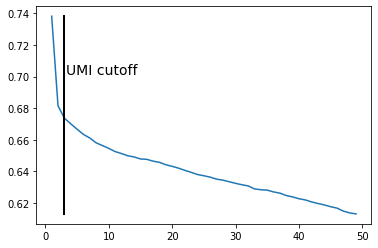

In [341]:
cell_data = {}
for lib,cell in zip(lib_names,cell_bcs):
    cell_data[(lib,cell)] = {}
print(lib,cell)
for lib,cell,umi,BC in counts_filtered.keys():
    if (lib,cell) in cell_data:
        if not BC in cell_data[(lib,cell)]:
            cell_data[(lib,cell)][BC] = 0
        cell_data[(lib,cell)][BC] += 1

xaxis = 50        
BC_lists = []
for i in range(1,xaxis):
    BC_list = []
    for lib,cell in zip(lib_names,cell_bcs):
        bc_counts = cell_data[(lib,cell)]
        valid_bcs = [bc_map[k] for k,v in bc_counts.items() if v >= i]
        BC_list.append(''.join(sorted(valid_bcs)))
    BC_lists.append(BC_list)

efficiency = np.array([len([ll for ll in l if len(ll)>0]) for l in BC_lists]) / len(cell_bcs)
plt.plot(range(1,xaxis),efficiency)
plt.plot([N_UMIS,N_UMIS],[np.min(efficiency),np.max(efficiency)],'-k',linewidth=2)
plt.text(N_UMIS*1.1,np.max(efficiency)*.95,'UMI cutoff',fontsize=14)

final_BCs = BC_lists[N_UMIS-1]
print('\nFinal annotation has '+repr(len(set(final_BCs)))+' clones in '+repr(len([l for l in final_BCs if len(l)>0]))+' cells')

In [342]:
# cell_data = {}
# for lib,cell in zip(lib_names,cell_bcs):
#     cell_data[(lib,cell)] = {}
# print(lib,cell)
# for lib,cell,umi,BC in counts_filtered.keys():
#     if (lib,cell) in cell_data:
#         if not BC in cell_data[(lib,cell)]:
#             cell_data[(lib,cell)][BC] = 0
#         cell_data[(lib,cell)][BC] += 1

# xaxis = 50        
# BC_lists = []
# for i in range(1,xaxis):
#     BC_list = []
#     for lib,cell in zip(lib_names,cell_bcs):
#         bc_counts = cell_data[(lib,cell)]
#         valid_bcs = [bc_map[k] for k,v in bc_counts.items() if v >= i]
#         BC_list.append(''.join(sorted(valid_bcs)))
#     BC_lists.append(BC_list)

# efficiency = np.array([len([ll for ll in l if len(ll)>0]) for l in BC_lists]) / len(cell_bcs)
# plt.plot(range(1,xaxis),efficiency)
# plt.plot([N_UMIS,N_UMIS],[np.min(efficiency),np.max(efficiency)],'-k',linewidth=2)
# plt.text(N_UMIS*1.1,np.max(efficiency)*.95,'UMI cutoff',fontsize=14)

# final_BCs = BC_lists[N_UMIS-1]
# print('\nFinal annotation has '+repr(len(set(final_BCs)))+' clones in '+repr(len([l for l in final_BCs if l!='']))+' cells')

In [343]:
# cell_data = {}
# for lib,cell in zip(lib_names,cell_bcs):
#     cell_data[(lib,cell)] = {}
# print(lib,cell)
# for lib,cell,umi,BC in counts_filtered.keys():
#     if (lib,cell) in cell_data:
#         if not BC in cell_data[(lib,cell)]:
#             cell_data[(lib,cell)][BC] = 0
#         cell_data[(lib,cell)][BC] += 1

# xaxis = 50        
# BC_lists = []
# for i in range(1,xaxis):
#     BC_list = []
#     for lib,cell in zip(lib_names,cell_bcs):
#         bc_counts = cell_data[(lib,cell)]
#         valid_bcs = [bc_map[k] for k,v in bc_counts.items() if v >= i]
#         BC_list.append(''.join(sorted(valid_bcs)))
#     BC_lists.append(BC_list)

# efficiency = np.array([len([ll for ll in l if len(ll)>0]) for l in BC_lists]) / len(cell_bcs)
# plt.plot(range(1,xaxis),efficiency)
# plt.plot([N_UMIS,N_UMIS],[np.min(efficiency),np.max(efficiency)],'-k',linewidth=2)
# plt.text(N_UMIS*1.1,np.max(efficiency)*.95,'UMI cutoff',fontsize=14)

# final_BCs = BC_lists[N_UMIS-1]
# print('\nFinal annotation has '+repr(len(set(final_BCs)))+' clones in '+repr(len([l for l in final_BCs if l!='']))+' cells')

In [344]:
freq = []
for lib,cell in zip(lib_names,cell_bcs):
    freq.append(len(cell_data[(lib,cell)].keys()))

In [345]:
freq[:10]

[2, 0, 0, 1, 1, 0, 0, 0, 0, 3]

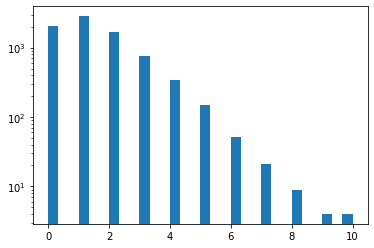

In [346]:
plt.hist(freq, bins=30)
plt.yscale('log')

In [347]:
freq = []
for lib,cell in zip(lib_names,cell_bcs):
    freq.append(len([cell_data[(lib,cell)][key] for key in cell_data[(lib,cell)].keys() if cell_data[(lib,cell)][key]>=N_UMIS]))
N_UMIS    

3

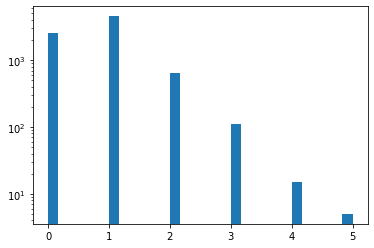

In [348]:
plt.hist(freq, bins=30)
plt.yscale('log')

In [349]:
len(BC_list), len(BC_lists)

(7897, 49)

## Output clonal anotations
There are three output files: 
- clone_mat.csv
- clone_mat.npy
- barcode_list.txt

The two clone_mat files store a binary matrix where rows are cells and columns are clones. A "1" at entry (i,j) indicates that cell i belongs to clone j. The barcode_list file stores the barcode for each cell. Two barcode strings separated by an underscore indicates that the cell contains multiple barcodes. An empty line implies no barcode for that cell.

(array([2577.,    0., 4547.,    0.,  641.,    0.,  112.,    0.,   15.,
           5.]),
 array([  0. ,  14.5,  29. ,  43.5,  58. ,  72.5,  87. , 101.5, 116. ,
        130.5, 145. ]),
 <BarContainer object of 10 artists>)

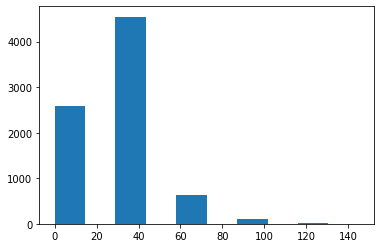

In [352]:
plt.hist(list(map(lambda x:len(x), final_BCs)))

In [353]:
len(final_BCs), len(set(final_BCs))

(7897, 4918)

In [354]:
testaa = list(set(final_BCs))
len(testaa)

4918

In [355]:
len([l for l in final_BCs if l!=''])

5320

In [356]:
len(set(sorted([bc for bc in final_BCs if bc != ''])))

4917

In [357]:
BC_set = sorted(set([bc for bc in final_BCs if bc != '']))
clone_mat = np.zeros((len(final_BCs),len(BC_set)))
for i,bc in enumerate(final_BCs):
    if bc != '':
        j = BC_set.index(bc)
        clone_mat[i,j] = 1
clone_mat = np.array(clone_mat,dtype=int)

In [358]:
clone_mat.shape, type(BC_set)

((7897, 4917), list)

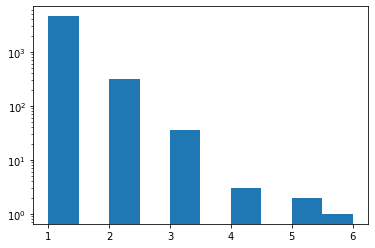

In [359]:
plt.hist(clone_mat.sum(axis=0))
plt.yscale('log')

In [360]:
# np.savetxt('RD_Larry_clone_mat.csv',clone_mat,delimiter=',',fmt='%i')
# np.save('RD_Larry_clone_mat.npy',clone_mat)
# open('RD_barcode_list.txt','w').write('\n'.join(final_BCs))

In [301]:
# np.savetxt('RD_larry_clone_mat_condition_specific.csv',clone_mat,delimiter=',',fmt='%i')
# np.save('RD_larry_clone_mat_condition_specific.npy',clone_mat)
# open('RD_larrybarcode_cell_list_condition_specific.txt','w').write('\n'.join(final_BCs))
# open('RD_larrybarcode_list_condition_specific.txt','w').write('\n'.join(list(BC_set)))

172681

In [361]:
np.savetxt('RD_larry_clone_mat_condition_specific2.csv',clone_mat,delimiter=',',fmt='%i')
np.save('RD_larry_clone_mat_condition_specific2.npy',clone_mat)
open('RD_larrybarcode_cell_list_condition_specific2.txt','w').write('\n'.join(final_BCs))
open('RD_larrybarcode_list_condition_specific2.txt','w').write('\n'.join(list(BC_set)))

172681

In [302]:
len(BC_set)

4917

In [303]:
clone_mat.shape

(7897, 4917)

In [304]:
final_BCs[:30]

['ATGATGTATACAAATAACAAATGATTGAGCTCCTGTCGACACCCGACTCGGGAAGGAG',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'AATCTGAGTCCAACACACTACCGAGGATGAATTTGATTGCACGAGACAGCCGACCTTG',
 'GTGCTGCATGCAATCGACCTTTGAATCCG',
 'AGATTGCAGACAGAAGACGGAAGAACGGG',
 'GACCTGTAGGCAAGTCACCCAAGAATCAG',
 '',
 'TAACTGAACCCAGAACACCGGAGAAATAGTGAGTGCGATCATGCAACATTAGACACGG',
 'TAACTGGTTTCACAGGACATTAGAGGAGG',
 '',
 'CAAGTGATACCAAGACACGTTAGAATATG',
 'GCACTGACACCAAGCCACAGTTGACGACG',
 'GATTTGAATACACACTACCTTGGACTAGGTGGATGATCACAAGAAACCTTTGACGAAG',
 '',
 '',
 '',
 '',
 'ATACTGCGAGCATATCACGCCCGAACTCG',
 'CTCGTGAGTACACATAACCTAAGACCTAG',
 'CAATTGCCACCACACGACCTCAGATTCTG',
 'ACTATGCAGTCATAGAACCACAGATAAGG',
 'ATATTGCCACCACGGCACAATTGAAAACGCCCCTGAATGCACTCCACAGTTGATTAAG',
 'CCAGTGAGGACACGAGACGCCAGACGAAGCCCCTGATGGCACTGGACAGACGACTATGGTGCTGACGCCACATAACAAGAGAATTAG']

In [362]:
cell_barcodes1 = pd.read_table('Differentiated/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)
cell_barcodes2 = pd.read_table('Regular/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)

cell_barcodes1.loc[:, 'library'] = 'Differentiated'
cell_barcodes2.loc[:, 'library'] = 'Regular'
cell_barcodes = pd.concat([cell_barcodes1, cell_barcodes2])

cell_barcodes.iloc[:, 0] = list(map(lambda x:x.split('-')[0], list(cell_barcodes.iloc[:, 0].values)))

In [363]:
cell_barcodes.shape

(7897, 2)

In [364]:
cell_barcodes.to_csv('RD_cellbarcode_list_condition_specific.txt')